# 2025 CITS4012 Project
*Make sure you change the file name with your group id.*

In [101]:
import pandas as pd
import numpy as np
import sys
import os 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
import copy
import random

import nltk
if not nltk.download('punkt'):
    nltk.download('punkt')
    nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

if not nltk.download('stopwords'):
    nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.utils.class_weight import compute_class_weight

import re
import pandas as pd
import numpy as np

# Stemmer and Lemmatizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

if not nltk.download('wordnet'):
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('averaged_perceptron_tagger')

sys.path.append(os.path.abspath('..')) 
import math


import torch
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA version: 12.4
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 3060


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Josh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Josh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Josh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [77]:
import time
import math

# Helper functions for training
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Readme

# 1.Dataset Processing


In [79]:
# Config
MIN_WORD_LENGTH = 3
MAX_WORD_LENGTH = 60 

# These are common English contractions.
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no match
    
# Allowed POS tags for filtering (example: nouns, verbs, adjectives, adverbs)
allowed_pos_tags = {'NN', 'NNS', 'NNP', 'NNPS',   # Nouns
                    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',  # Verbs
                    'JJ', 'JJR', 'JJS',           # Adjectives
                    'RB', 'RBR', 'RBS'}           # Adverbs

# Filter the desired POS tags
def filter_tokens_by_pos(tokens):
    tagged_tokens = pos_tag(tokens)
    filtered = [word for word, tag in tagged_tokens if tag in allowed_pos_tags]
    return filtered

def clean_dataset(dataset, MIN_WORD_LENGTH=3, MAX_WORD_LENGTH=60, method=['stem, lemmatize'], pos_filter=False, stop_w=False):
    cleaned_premises = []
    cleaned_hypotheses = []
    cleaned_labels = []

    for index, row in dataset.iterrows():
        premise = row['premise']
        hypothesis = row['hypothesis']
        label = row['label']

        # Lowercase
        premise = premise.lower()
        hypothesis = hypothesis.lower()

        # Expand contractions
        for contraction, full_form in contraction_dict.items():
            premise = premise.replace(contraction, full_form)
            hypothesis = hypothesis.replace(contraction, full_form)

        # Remove punctuation/special chars
        premise = re.sub(r'[^\w\s]', '', premise)
        hypothesis = re.sub(r'[^\w\s]', '', hypothesis)

        # Replace underscores/hyphens with spaces, then normalize whitespace
        premise = re.sub(r'[-–—_]+', ' ', premise)
        hypothesis = re.sub(r'[-–—_]+', ' ', hypothesis)

        # Normalize whitespace
        premise = re.sub(r'\s+', ' ', premise).strip()
        hypothesis = re.sub(r'\s+', ' ', hypothesis).strip()


        # Tokenization
        premise_tokens = word_tokenize(premise)
        hypothesis_tokens = word_tokenize(hypothesis)

        # # Replace numbers with '<NUM>'
        # premise_tokens = ['[NUM]' if any(char.isdigit() for char in word) else word for word in premise_tokens]
        # hypothesis_tokens = ['[NUM]' if any(char.isdigit() for char in word) else word for word in hypothesis_tokens]


        # Stemming/Lemmatization
        if 'stem' in method:
            stemmer = PorterStemmer()
            premise_tokens = [stemmer.stem(word) for word in premise_tokens]
            hypothesis_tokens = [stemmer.stem(word) for word in hypothesis_tokens]
        elif 'lemmatize' in method:
            lemmatizer = WordNetLemmatizer()
            premise_pos_tags = pos_tag(premise_tokens)
            hypothesis_pos_tags = pos_tag(hypothesis_tokens)
            premise_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in premise_pos_tags]
            hypothesis_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in hypothesis_pos_tags]

        # POS Filtering
        if pos_filter:
            premise_tokens = filter_tokens_by_pos(premise_tokens)
            hypothesis_tokens = filter_tokens_by_pos(hypothesis_tokens)

        # Remove stop words
        if stop_w:
            premise_tokens = [word for word in premise_tokens if word not in stop_words]
            hypothesis_tokens = [word for word in hypothesis_tokens if word not in stop_words]

        # Now check token length AFTER cleaning
        if (MIN_WORD_LENGTH <= len(premise_tokens) <= MAX_WORD_LENGTH and
            MIN_WORD_LENGTH <= len(hypothesis_tokens) <= MAX_WORD_LENGTH):
            cleaned_premises.append(premise_tokens)
            cleaned_hypotheses.append(hypothesis_tokens)
            cleaned_labels.append(label)
        # else: skip row

    # Build DataFrame from all cleaned token lists
    new_dataset = pd.DataFrame({
        'premise': cleaned_premises,
        'hypothesis': cleaned_hypotheses,
        'label': cleaned_labels
    })

    return new_dataset

## 1.1 Make the Datasets

In [80]:
# Load raw data
train_df = pd.read_json('Dataset/train.json')
test_df = pd.read_json('Dataset/test.json')
validation_df = pd.read_json('Dataset/validation.json')

# Clean datasets. MAX_WORD_LENGTH set to 64 to remove very long texts
clean_train_dataset = clean_dataset(train_df, MIN_WORD_LENGTH=3, MAX_WORD_LENGTH=64, stop_w=True, method=[], pos_filter=False)
clean_test_dataset = clean_dataset(test_df, MIN_WORD_LENGTH=3, MAX_WORD_LENGTH=64,stop_w=True, method=[], pos_filter= False )
clean_validation_dataset = clean_dataset(validation_df, MIN_WORD_LENGTH=3, MAX_WORD_LENGTH=64,stop_w=True, method=[], pos_filter= False )

# Combine clean premises and hypotheses
clean_t_dataset = clean_train_dataset['premise'] + clean_train_dataset['hypothesis']
clean_t_dataset.head()

0    [pluto, rotates, axis, every, 639, earth, days...
1    [glenn, per, day, earth, rotates, axis, earth,...
2    [geysers, periodic, gush, hot, water, surface,...
3    [facts, liquid, water, droplets, changed, invi...
4    [comparison, earth, rotates, axis, per, day, r...
dtype: object

In [81]:
sum(train_df['label']=='entails') / (sum(train_df['label']!='entails') + sum(train_df['label']=='entails'))

0.36685724185724183

In [82]:
sum(validation_df['label']=='entails') / (sum(validation_df['label']!='entails') + sum(validation_df['label']=='entails'))

0.5038343558282209

In [83]:
sum(test_df['label']=='entails') / (sum(test_df['label']!='entails') + sum(test_df['label']=='entails'))

0.39604891815616183

In [86]:
# Create a unique word list from the cleaned dataset
unique_words = set()
for sentence in clean_t_dataset: # Both Premise and Hypothesis 
    for word in sentence:
        unique_words.add(word)
        
unique_words_list = sorted(list(unique_words))

# Make dictionary of words and indices
word2id = {w:i for i,w in enumerate(unique_words_list)}
id2word = {i:w for i,w in enumerate(unique_words_list)}


# Add special tokens to use later
SPECIAL_TOKENS = ['[PAD]','[UNK]','[CLS]','[SEP]'] # And [NUM] added during cleaning
for tok in SPECIAL_TOKENS:
    if tok not in word2id:
        idx = len(word2id)
        word2id[tok] = idx
        id2word[idx] = tok

VOCAB_SIZE = len(word2id)
print(f"Vocab size (including special tokens): {VOCAB_SIZE}")

Vocab size (including special tokens): 21914


In [ ]:
SEP_ID = word2id['[SEP]']
UNK_ID = word2id['[UNK]']
PAD_ID = word2id['[PAD]']
CLS_ID = word2id['[CLS]']


def prepare_indexed_data(df, word2id, max_len):
    input_ids = []
    attention_mask = []
    labels = []

    label_map = {'neutral': 0, 'entails': 1}

    for _, row in df.iterrows():
        premise_toks = row['premise']
        hypothesis_toks = row['hypothesis']
        label = row['label']

        # Add special tokens 
        tokens = [CLS_ID] \
                + [word2id.get(w,UNK_ID) for w in premise_toks] \
                + [SEP_ID] \
                + [word2id.get(w,UNK_ID) for w in hypothesis_toks] 
        # Truncate
        tokens = tokens[:max_len]

        # Attention mask 
        attn = [1] * len(tokens)

        # Pad
        pad_len = max_len- len(tokens) # To fill the [PAD]
        if pad_len > 0:
            tokens += [PAD_ID] * pad_len
            attn += [0] * pad_len # FLag positions as padding 

        input_ids.append(tokens)
        attention_mask.append(attn)
        labels.append(label_map[label])

    return (torch.LongTensor(input_ids),
            np.array(input_ids),
            torch.LongTensor(attention_mask),
            torch.LongTensor(labels))

Shape of x_train: torch.Size([22621, 64])
Shape of train_masks: torch.Size([22621, 64])
Shape of y_train: torch.Size([22621])

--- Example ---
First example real length (mask sum): 15
First example PAD count: 49


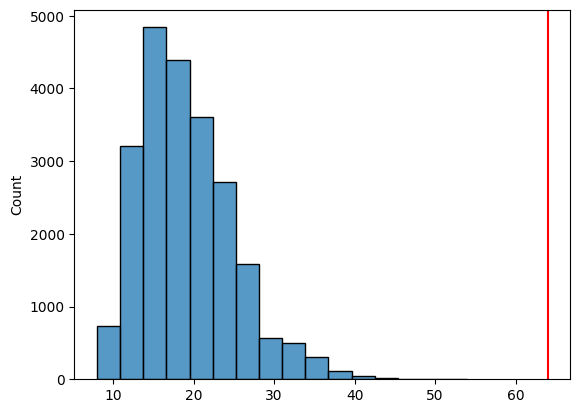

In [88]:
MAX_SEQ_LEN = 64
#embedding_size

# Build train/test
x_train, plain_train, train_masks, y_train = prepare_indexed_data(clean_train_dataset, word2id, MAX_SEQ_LEN)
x_test,  plain_test, test_masks,  y_test  = prepare_indexed_data(clean_test_dataset,  word2id, MAX_SEQ_LEN)
x_valid,  plain_valid, valid_masks,  y_valid  = prepare_indexed_data(clean_validation_dataset,  word2id, MAX_SEQ_LEN)

print("Shape of x_train:", x_train.shape)
print("Shape of train_masks:", train_masks.shape)
print("Shape of y_train:", y_train.shape)

# Sanity Check 
i = 0
print("\n--- Example ---")
print("First example real length (mask sum):", int(train_masks[i].sum()))
print("First example PAD count:", int((train_masks[i]==0).sum()))


# Check we didn't cut off too much
sns.histplot(np.sum(train_masks.numpy(), axis=1), bins = 16)
plt.axvline(MAX_SEQ_LEN, color='red')
plt.show()


# Prepare the datasets for model training
train_ds = TensorDataset(x_train, train_masks, y_train)
test_ds = TensorDataset(x_test, test_masks,y_test)
valid_ds = TensorDataset(x_valid, valid_masks,y_valid)

BATCH_SIZE = 256
# Dataloaders (shuffle for train)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [89]:
# Get the first batch from the train_loader Get the first batch from the train_loader

## 1.1 Make an embedding model

In [90]:
from gensim.models import FastText

embedding_dim = 200

fast_text_model = FastText(clean_t_dataset, # Both premise and Hypothesis 
                           vector_size=embedding_dim,
                           window=3,
                           sg=1,
                           epochs=16
                           )

fast_text_model.wv.most_similar('saturn', topn=10)

def build_embedding_matrix(word2id, pretrained_vectors, embedding_size):
    vocab_size = len(word2id)
    embedding_matrix = np.zeros((vocab_size, embedding_size), dtype=np.float32)

    # Fill the matrix with pre-trained vectors
    for word, idx in word2id.items():
        if word == '[PAD]':
            continue
        try:
            vec = pretrained_vectors[word]
            if vec.shape[0] == embedding_size:
                embedding_matrix[idx] = vec.astype(np.float32)
            else:
                # fallback if dims don’t match
                embedding_matrix[idx] = np.random.normal(0.0, 0.02, size=(embedding_size,)).astype(np.float32)
        except KeyError:
            # special tokens or OOV start them with random values 
            embedding_matrix[idx] = np.random.normal(0.0, 0.02, size=(embedding_size,)).astype(np.float32)

    print("Embedding matrix created with shape:", embedding_matrix.shape)

    return embedding_matrix


embedding_matrix = build_embedding_matrix(word2id, fast_text_model.wv, embedding_dim)

Embedding matrix created with shape: (21914, 200)


# 2. Model Implementation

Note we have collected following parameters from the pre-processing:
- VOCAB_SIZE
- MAX_SEQ_LEN
- BATCH_SIZE
- embedding_dim
We have collected the objects:
- embedding_matrix
- fast_text_model
- clean_train_dataset, clean_test_dataset, clean_validation_dataset

# Global Helper Functions

In [ ]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    for xb, mb, yb in loader:  # x, mask, y
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device).long()
        optimizer.zero_grad()
        out = model(xb, mb)

        # handle models that return (logits, ...) vs logits
        logits = out[0] if isinstance(out, (tuple, list)) else out

        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        batch_size = yb.size(0)
        total_loss += loss.item() * batch_size
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total += batch_size

    return total_loss / total, total_correct / total

@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    y_train_np = y_train.cpu().numpy()
    weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))

    for xb, mb, yb in loader:
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device).long()
        out = model(xb, mb)
        logits = out[0] if isinstance(out, (tuple, list)) else out

        loss = criterion(logits, yb)
        batch_size = yb.size(0)
        total_loss += loss.item() * batch_size
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total += batch_size

    return total_loss / total, total_correct / total


def train_model(model, train_loader, valid_loader, optimizer, n_epochs=10, patience=3):
    best_val_acc = 0.0
    epochs_no_improve = 0
    best_model_state = None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer)
        val_loss, val_acc = evaluate_model(model, valid_loader)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{n_epochs} - "
              f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} - "
              f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history

## Model A: RNN with Attention (placeholder)

In [ ]:
class LSTMAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2, dropout=0.3):
        super(LSTMAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, x, mask=None):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        context = self.dropout(context)
        return self.fc(context)

In [135]:
class GRUAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout=0.3, unk_prob=0.1):
        super(GRUAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=dropout)
        self.norm = nn.LayerNorm(hidden_dim * 2)
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)
        self.unk_id = UNK_ID
        self.unk_prob = unk_prob

    def forward(self, x, mask=None):
        # Only replace tokens during training
        if self.training and self.unk_prob > 0:
            mask = (x != PAD_ID) & (x != SEP_ID) & (x != CLS_ID) & (x != UNK_ID)
            replace_mask = (torch.rand_like(x.float()) < self.unk_prob) & mask
            x = torch.where(replace_mask, torch.full_like(x, self.unk_id), x)
        # Rest of the forward pass...
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = self.norm(gru_out)
        attn_weights = torch.softmax(self.attention(gru_out), dim=1)
        context = torch.sum(attn_weights * gru_out, dim=1)
        context = self.dropout(context)
        return self.fc(context)



In [146]:
LR = 1e-3
WD = 1e-2

GRU_model = GRUAttentionModel(
    vocab_size=VOCAB_SIZE,
    embedding_dim=100,
    hidden_dim=128,
    dropout=0.5,
    unk_prob=0.7
).to(device)

optimizer = torch.optim.AdamW(GRU_model.parameters(), lr=LR, weight_decay=WD)

# train 
trained_GRU_model, history = train_model(GRU_model, train_loader, valid_loader, optimizer, n_epochs=20, patience=5)

Epoch 1/20 - Train loss: 0.6805, Train acc: 0.6050 - Val loss: 0.8151, Val acc: 0.5111
Epoch 2/20 - Train loss: 0.6517, Train acc: 0.6292 - Val loss: 0.6670, Val acc: 0.6249
Epoch 3/20 - Train loss: 0.6078, Train acc: 0.6689 - Val loss: 0.7907, Val acc: 0.6449
Epoch 4/20 - Train loss: 0.5720, Train acc: 0.7010 - Val loss: 0.8312, Val acc: 0.6364
Epoch 5/20 - Train loss: 0.5494, Train acc: 0.7214 - Val loss: 0.9787, Val acc: 0.6357
Epoch 6/20 - Train loss: 0.5301, Train acc: 0.7383 - Val loss: 0.9277, Val acc: 0.6472
Epoch 7/20 - Train loss: 0.5118, Train acc: 0.7501 - Val loss: 0.9976, Val acc: 0.6364
Epoch 8/20 - Train loss: 0.5049, Train acc: 0.7539 - Val loss: 0.8094, Val acc: 0.6357
Epoch 9/20 - Train loss: 0.4907, Train acc: 0.7624 - Val loss: 0.8321, Val acc: 0.6503
Epoch 10/20 - Train loss: 0.4789, Train acc: 0.7714 - Val loss: 0.9131, Val acc: 0.6572
Epoch 11/20 - Train loss: 0.4749, Train acc: 0.7711 - Val loss: 0.8769, Val acc: 0.6449
Epoch 12/20 - Train loss: 0.4599, Train a

In [151]:
# Make sure the model is in evaluation mode
GRU_model.eval()

predictions = []
all_labels = []
# Disable gradient computation for inference
with torch.no_grad():
    for batch in valid_loader:
        # Assuming your batch is (inputs, labels)
        inputs, _, labels = batch
        inputs = inputs.to(device)
        
        # Forward pass
        outputs = GRU_model(inputs)
        
        # If this is classification, pick the class with highest probability
        _, preds = torch.max(outputs, dim=1)
        
        # Convert to CPU and numpy if needed, then append
        predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        
correct = (predictions == np.array(all_labels))

# 'predictions' is now a list of predicted class indices

print(np.sum(correct) / len(correct))


contain_UNK = np.zeros(len(plain_valid), dtype=bool)
for i, sent in enumerate(plain_valid):
    if UNK_ID in sent:
        contain_UNK[i] = True


# Calculate accuracy for samples with UNK tokens
unk_correct = correct[contain_UNK]
unk_accuracy = np.sum(unk_correct) / len(unk_correct) if len(unk_correct) > 0 else 0

# Calculate accuracy for samples without UNK tokens
no_unk_correct = correct[~contain_UNK]
no_unk_accuracy = np.sum(no_unk_correct) / len(no_unk_correct) if len(no_unk_correct) > 0 else 0

print(f"Accuracy on samples with UNK tokens: {unk_accuracy:.4f}")
print(f"Accuracy on samples without UNK tokens: {no_unk_accuracy:.4f}")
print(f"Number of samples with UNK tokens: {len(unk_correct)}")
print(f"Number of samples without UNK tokens: {len(no_unk_correct)}")

0.6671790930053805
Accuracy on samples with UNK tokens: 0.6568
Accuracy on samples without UNK tokens: 0.6731
Number of samples with UNK tokens: 472
Number of samples without UNK tokens: 829


In [98]:
class LSTMAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2, dropout=0.3):
        super(LSTMAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, x, mask=None):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        context = self.dropout(context)
        return self.fc(context)

In [99]:
def train_lstm_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0

        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
# Run LSTM with Attention
print("="*60)
print("TRAINING LSTM WITH ATTENTION")
print("="*60)
model_lstm_attn = LSTMAttentionModel(
    vocab_size=len(word2id), 
    embedding_dim=200, 
    hidden_dim=128
)
train_lstm_attention(model_lstm_attn, train_loader, valid_loader, num_epochs=5, lr=0.001)

TRAINING LSTM WITH ATTENTION
Epoch 1/5 | Train Loss: 0.5886 | Train Acc: 0.6946 | Val Loss: 0.8036 | Val Acc: 0.6164
Epoch 2/5 | Train Loss: 0.4250 | Train Acc: 0.8148 | Val Loss: 0.8137 | Val Acc: 0.6449


KeyboardInterrupt: 

In [ ]:
LR = 1e-3
WD = 1e-2

GRU_model = LSTMAttentionModel(
    vocab_size=VOCAB_SIZE,
    embedding_dim=200,
    hidden_dim=128,
    dropout=0.3
).to(device)

optimizer = torch.optim.AdamW(GRU_model.parameters(), lr=LR, weight_decay=WD)

# train 
trained_GRU_model, history = train_model(GRU_model, train_loader, valid_loader, optimizer, n_epochs=10, patience=3)

Epoch 1/10 - Train loss: 0.6013, Train acc: 0.6831 - Val loss: 0.6766, Val acc: 0.6434
Epoch 2/10 - Train loss: 0.4318, Train acc: 0.8161 - Val loss: 0.7396, Val acc: 0.6395
Epoch 3/10 - Train loss: 0.3442, Train acc: 0.8596 - Val loss: 0.7335, Val acc: 0.6364
Epoch 4/10 - Train loss: 0.2642, Train acc: 0.8985 - Val loss: 0.7835, Val acc: 0.6679
Epoch 5/10 - Train loss: 0.1853, Train acc: 0.9313 - Val loss: 0.9851, Val acc: 0.6426
Epoch 6/10 - Train loss: 0.1281, Train acc: 0.9550 - Val loss: 1.0933, Val acc: 0.6695
Epoch 7/10 - Train loss: 0.0888, Train acc: 0.9709 - Val loss: 1.3221, Val acc: 0.6687
Epoch 8/10 - Train loss: 0.0660, Train acc: 0.9782 - Val loss: 1.4635, Val acc: 0.6580
Epoch 9/10 - Train loss: 0.0481, Train acc: 0.9836 - Val loss: 1.6016, Val acc: 0.6357
Early stopping triggered.


## Model B: Transformer with Attention

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len = 512, dropout = 0.1):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0,max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0) / d_model))
        pe[:,0::2] = torch.sin(position * div_term) # For even dims
        pe[:,1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        x = x + self.pe[:, :x.size(1), :] 
        return self.dropout(x)

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes, n_heads, n_layers, dropout):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim

        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False, padding_idx=word2id['[PAD]'])

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=MAX_SEQ_LEN, dropout=dropout)

        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dropout=dropout,
            dim_feedforward=256,
            batch_first=True # Makes working with batch dimension easier
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,num_layers=n_layers)

        # Final Classification Head
        self.classifier = nn.Linear(embed_dim,num_classes)

    def forward(self, src, src_mask):
        padding_mask = (src_mask == 0)

        # Apply embedding and positional encoding
        embedded = self.embedding(src) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)

        # Pass trough the transformer encoder
        encoded = self.transformer_encoder(pos_encoded,src_key_padding_mask = padding_mask)

        # Use the output of the [CLS] token (first token) for classification
        cls_output = encoded[:,0,:]

        # Get final logits from the classifier
        logits = self.classifier(cls_output)
        return logits

In [ ]:
# Transformer Hyperparameters
N_HEADS = 8
N_LAYERS = 4
DROPOUT = 0.5
NUM_CLASSES = 2
LR = 0.0002
WD = 0.2
NUM_EPOCHS = 50

# Now, instantiate the model
transformer_model = TransformerClassifier(
    embedding_matrix=embedding_matrix,
    num_classes=NUM_CLASSES,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    dropout=DROPOUT
)


transformer_model.to(device)
optimizer = torch.optim.AdamW(transformer_model.parameters(), lr = LR, weight_decay=WD)


model, history = train_model(transformer_model, train_loader, valid_loader, optimizer, n_epochs=10, patience=3)

c:\Users\Josh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 1/10 - Train loss: 0.6702, Train acc: 0.6113 - Val loss: 0.6467, Val acc: 0.6664
Epoch 2/10 - Train loss: 0.6339, Train acc: 0.6458 - Val loss: 0.7828, Val acc: 0.5772
Epoch 3/10 - Train loss: 0.6127, Train acc: 0.6711 - Val loss: 0.6933, Val acc: 0.6126
Epoch 4/10 - Train loss: 0.6011, Train acc: 0.6786 - Val loss: 0.7174, Val acc: 0.6272
Early stopping triggered.


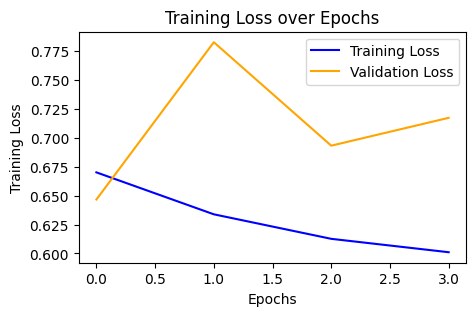

In [ ]:
# Compare the losses of the two models
plt.figure(figsize=(5,3))
plt.plot(history['train_loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

## Model C: Wide and Deep RNN
This model seeks to build on Model A by splitting into three components

In [226]:
class GRUThreeStreamNLI(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, wide_layers=2, prem_layers=2, hypo_layers=2, num_fc_layers=2, embedding_dropout=0.2, dropout=0.3, unk_prob=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embed_dropout = nn.Dropout(embedding_dropout)
        self.dropout = nn.Dropout(dropout)

        # Encoders
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True,
                          bidirectional=True, num_layers=wide_layers, dropout=dropout if wide_layers > 1 else 0.0)
        self.prem_encoder = nn.GRU(
            embedding_dim, hidden_dim, num_layers=prem_layers,
            batch_first=True, bidirectional=True, dropout=dropout if prem_layers > 1 else 0.0
        )
        self.hypo_encoder = nn.GRU(
            embedding_dim, hidden_dim, num_layers=hypo_layers,
            batch_first=True, bidirectional=True, dropout=dropout if hypo_layers > 1 else 0.0
        )

        self.norm = nn.LayerNorm(hidden_dim * 2)


        # Self-attention for premise and hypothesis
        self.self_attn = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        # Cross-attention for the wide stream
        self.cross_attn_query = nn.Linear(hidden_dim * 2, hidden_dim)
        self.cross_attn_key = nn.Linear(hidden_dim * 2, hidden_dim)
        self.cross_attn_value = nn.Linear(hidden_dim * 2, hidden_dim)

        # Fusion and classification layers
        fusion_dim = hidden_dim * (4 + 2 + 2)  # 4H from cross + 2H + 2H = 8H total
        fc_layers = []
        in_dim = fusion_dim
        out_dim = hidden_dim * 2

        for i in range(num_fc_layers):
            fc_layers.extend([
                nn.Linear(in_dim, out_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            # for next layer
            in_dim = out_dim
            # Optionally shrink layer width gradually:
            out_dim = max(hidden_dim, out_dim // 2)

        self.fc_layers = nn.Sequential(*fc_layers)
        self.classifier = nn.Linear(in_dim, 2)
        self.unk_id = UNK_ID
        self.unk_prob = unk_prob


    def forward(self, x, mask=None):
        # Token corruption (word dropout)
        if self.training and self.unk_prob > 0:
            mask = (x != PAD_ID) & (x != SEP_ID) & (x != CLS_ID) & (x != UNK_ID)
            replace_mask = (torch.rand_like(x.float()) < self.unk_prob) & mask
            x = torch.where(replace_mask, torch.full_like(x, self.unk_id), x)

        # Split into premise/hypothesis 
        sep_positions = (x == SEP_ID).int().argmax(dim=1)
        batch_idx = torch.arange(x.size(0), device=x.device)
        token_range = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        premise_mask = token_range < sep_positions.unsqueeze(1)
        hypothesis_mask = token_range > sep_positions.unsqueeze(1)
        premise = torch.where(premise_mask, x, PAD_ID)
        hypothesis = torch.where(hypothesis_mask, x, PAD_ID)

        #  Embeddings
        embedded = self.embed_dropout(self.embedding(x).transpose(1,2)).transpose(1,2)
        emb_prem = self.embed_dropout(self.embedding(premise).transpose(1,2)).transpose(1,2)
        emb_hypo = self.embed_dropout(self.embedding(hypothesis).transpose(1,2)).transpose(1,2)

        # Encode all three streams
        full_out, _ = self.gru(embedded)
        prem_out, _ = self.gru(emb_prem)
        hypo_out, _ = self.gru(emb_hypo)

        full_out = self.norm(full_out)
        prem_out, _ = self.prem_encoder(emb_prem)
        hypo_out, _ = self.hypo_encoder(emb_hypo)

        # # Wide stream (cross-attention over full sequence)
        # Q = self.cross_attn_query(full_out)
        # K = self.cross_attn_key(full_out)
        # V = self.cross_attn_value(full_out)
        # attn_scores = torch.bmm(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        # attn_weights = F.softmax(attn_scores, dim=-1)
        # cross_context = torch.bmm(attn_weights, V).mean(dim=1)  # (B, hidden_dim)

        # --- Bidirectional cross-attention between premise and hypothesis ---
        # Project to query/key/value spaces
        Q_p = self.cross_attn_query(prem_out)   # (B, Lp, H)
        K_h = self.cross_attn_key(hypo_out)
        V_h = self.cross_attn_value(hypo_out)

        Q_h = self.cross_attn_query(hypo_out)   # (B, Lh, H)
        K_p = self.cross_attn_key(prem_out)
        V_p = self.cross_attn_value(prem_out)

        # Premise → Hypothesis attention (H attends to P)
        scores_h2p = torch.bmm(Q_h, K_p.transpose(1, 2)) / (Q_h.size(-1) ** 0.5)
        weights_h2p = F.softmax(scores_h2p, dim=-1)
        context_h2p = torch.bmm(weights_h2p, V_p)  # (B, Lh, H)

        # Hypothesis → Premise attention (P attends to H)
        scores_p2h = torch.bmm(Q_p, K_h.transpose(1, 2)) / (Q_p.size(-1) ** 0.5)
        weights_p2h = F.softmax(scores_p2h, dim=-1)
        context_p2h = torch.bmm(weights_p2h, V_h)  # (B, Lp, H)

        # Pool both directions
        context_h2p = context_h2p.mean(dim=1)  # (B, H)
        context_p2h = context_p2h.mean(dim=1)  # (B, H)

        # Fuse bidirectional cross contexts
        cross_context = torch.cat([
            context_p2h,                   # P→H
            context_h2p,                   # H→P
            torch.abs(context_p2h - context_h2p),  # difference
            context_p2h * context_h2p              # element-wise product
        ], dim=1)  # (B, 4H)

        # Deep streams (self-attention pooling)
        def self_attention_pooling(out):
            weights = F.softmax(self.self_attn(out), dim=1)  # (B, L, 1)
            return torch.sum(weights * out, dim=1)           # (B, 2H)

        prem_context = self_attention_pooling(prem_out)
        hypo_context = self_attention_pooling(hypo_out)

        # Fusion
        fused = torch.cat([cross_context, prem_context, hypo_context], dim=1)
        fused = self.fc_layers(fused)
        logits = self.classifier(fused)

        return logits

In [229]:
contain_UNK = np.zeros(len(plain_valid), dtype=bool)
for i, sent in enumerate(plain_valid):
    if UNK_ID in sent:
        contain_UNK[i] = True

In [203]:
LR = 0.002
WD = 0.01
GRU_model = GRUThreeStreamNLI(
    vocab_size=VOCAB_SIZE,
    embedding_dim=300,
    hidden_dim=128, 
    wide_layers=2, 
    prem_layers=4, 
    hypo_layers=2, 
    num_fc_layers=2,
    embedding_dropout=0.2,
    dropout=0.5, 
    unk_prob=0.1
).to(device)

optimizer = torch.optim.AdamW(GRU_model.parameters(), lr=LR, weight_decay=WD)
# train 
trained_GRU_model, history = train_model(GRU_model, train_loader, valid_loader, optimizer, n_epochs=10, patience=5)

Epoch 1/10 - Train loss: 0.6240, Train acc: 0.6670 - Val loss: 0.7157, Val acc: 0.6726
Epoch 2/10 - Train loss: 0.4662, Train acc: 0.7963 - Val loss: 0.6975, Val acc: 0.6695
Epoch 3/10 - Train loss: 0.3908, Train acc: 0.8341 - Val loss: 0.7808, Val acc: 0.6756
Epoch 4/10 - Train loss: 0.3376, Train acc: 0.8604 - Val loss: 0.7621, Val acc: 0.6726
Epoch 5/10 - Train loss: 0.2947, Train acc: 0.8802 - Val loss: 0.8507, Val acc: 0.6949
Epoch 6/10 - Train loss: 0.2460, Train acc: 0.9045 - Val loss: 1.0338, Val acc: 0.6887
Epoch 7/10 - Train loss: 0.2032, Train acc: 0.9217 - Val loss: 0.9053, Val acc: 0.6964
Epoch 8/10 - Train loss: 0.1791, Train acc: 0.9317 - Val loss: 1.2188, Val acc: 0.6979
Epoch 9/10 - Train loss: 0.1539, Train acc: 0.9431 - Val loss: 1.2152, Val acc: 0.6902
Epoch 10/10 - Train loss: 0.1344, Train acc: 0.9505 - Val loss: 1.4603, Val acc: 0.6979



🔧 Training model with 1
Epoch 1/10 - Train loss: 0.6616, Train acc: 0.6279 - Val loss: 0.7740, Val acc: 0.4950
Epoch 2/10 - Train loss: 0.6067, Train acc: 0.6656 - Val loss: 0.6931, Val acc: 0.6556
Epoch 3/10 - Train loss: 0.4840, Train acc: 0.7866 - Val loss: 0.7011, Val acc: 0.6641
Epoch 4/10 - Train loss: 0.4175, Train acc: 0.8301 - Val loss: 0.7223, Val acc: 0.6695
Epoch 5/10 - Train loss: 0.3730, Train acc: 0.8507 - Val loss: 0.7995, Val acc: 0.6818
Epoch 6/10 - Train loss: 0.3297, Train acc: 0.8725 - Val loss: 0.7794, Val acc: 0.6772
Epoch 7/10 - Train loss: 0.2982, Train acc: 0.8825 - Val loss: 0.9188, Val acc: 0.6779
Epoch 8/10 - Train loss: 0.2727, Train acc: 0.8916 - Val loss: 0.9162, Val acc: 0.6902
Epoch 9/10 - Train loss: 0.2428, Train acc: 0.9093 - Val loss: 1.2167, Val acc: 0.6918
Epoch 10/10 - Train loss: 0.2224, Train acc: 0.9155 - Val loss: 1.0846, Val acc: 0.6910
✅ param=1 | Val Acc=0.6910 | Time=0.33 min

🔧 Training model with 2
Epoch 1/10 - Train loss: 0.6586, Tra

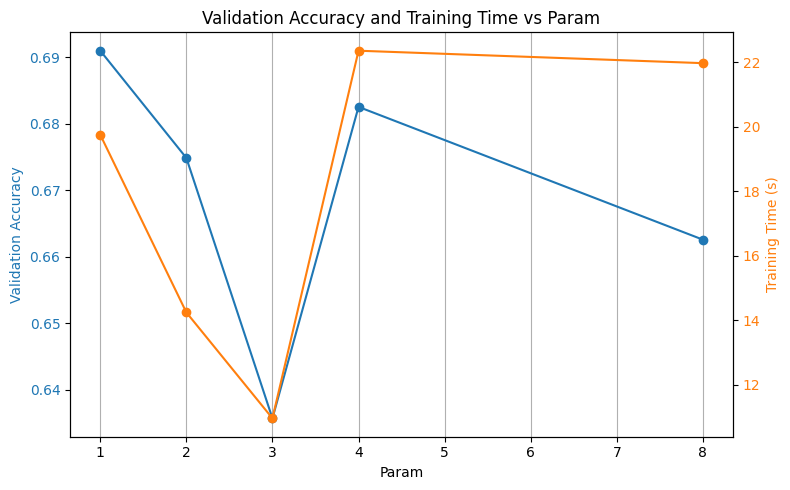

In [ ]:
accs = []
times = []
params = [1, 2, 3, 4, 5, 6, 7, 8]
UNKS_acc = []
NOUNKS_acc = []

for p in params:
    print(f"\n🔧 Training model with {p}")
    start_time = time.time()
    LR = 0.002
    WD = 0.01
    GRU_model = GRUThreeStreamNLI(
        vocab_size=VOCAB_SIZE,
        embedding_dim=256,
        hidden_dim=32,
        wide_layers=2,
        prem_layers=p,
        hypo_layers=3,
        num_fc_layers=4,
        embedding_dropout=0.2,
        dropout=0.5,
        unk_prob=0.1
    ).to(device)
    optimizer = torch.optim.AdamW(GRU_model.parameters(), lr=LR, weight_decay=WD)
    trained_GRU_model, history = train_model(GRU_model, train_loader, valid_loader, optimizer, n_epochs=10, patience=8)
    end_time = time.time()
    duration = end_time - start_time
    acc = history["val_acc"][-1]
    accs.append(acc)
    times.append(duration)

    # # UNK Thing
    # GRU_model.eval()
    # predictions = []
    # all_labels = []
    # with torch.no_grad():
    #     for batch in valid_loader:
    #         inputs, _, labels = batch
    #         inputs = inputs.to(device)
    #         outputs = GRU_model(inputs)
    #         _, preds = torch.max(outputs, dim=1)
    #         predictions.extend(preds.cpu().numpy())
    #         all_labels.extend(labels.numpy())
    # correct = (predictions == np.array(all_labels))
    # unk_correct = correct[contain_UNK]
    # UNKS_acc.append(np.sum(unk_correct) / len(unk_correct) if len(unk_correct) > 0 else 0)
    # no_unk_correct = correct[~contain_UNK]
    # NOUNKS_acc.append(np.sum(no_unk_correct) / len(no_unk_correct) if len(no_unk_correct) > 0 else 0)

    print(f"✅ param={p} | Val Acc={acc:.4f} | Time={duration/60:.2f} min")

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel("Param")
ax1.set_ylabel("Validation Accuracy", color='tab:blue')
ax1.plot(params, accs, marker='o', color='tab:blue', label='Validation Accuracy')
# ax1.plot(params, UNKS_acc, marker='o', color='tab:green', label='UNK Accuracy')
# ax1.plot(params, NOUNKS_acc, marker='o', color='tab:purple', label='NO UNK Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, axis='x')
ax2 = ax1.twinx()
ax2.set_ylabel("Training Time (s)", color='tab:orange')
ax2.plot(params, times, marker='o', color='tab:orange', label='Training Time')
ax2.tick_params(axis='y', labelcolor='tab:orange')
plt.title("Validation Accuracy and Training Time vs Param")
fig.tight_layout()
plt.show()

In [ ]:
accs= []

for d in [0.2, 0.4, 0.6]:
    LR = 0.002
    WD = 0.01
    GRU_model = GRUThreeStreamNLI(
        vocab_size=VOCAB_SIZE,
        embedding_dim=256,
        hidden_dim=128, 
        wide_layers=2, 
        prem_layers=2, 
        hypo_layers=2, 
        embedding_dropout=d/4,
        dropout=d, 
        unk_prob=0.1
    ).to(device)

    optimizer = torch.optim.AdamW(GRU_model.parameters(), lr=LR, weight_decay=WD)
    # train 
    trained_GRU_model, history = train_model(GRU_model, train_loader, valid_loader, optimizer, n_epochs=10, patience=3)
    accs.append(history["val_acc"][-1])

plt.plot(edim, accs)

In [ ]:
# Define search space
param_grid = {
    "embedding_dim": [100, 200, 300],
    "hidden_dim": [64, 128, 256],
    "dropout": [0.3, 0.4, 0.5],
    "unk_prob": [0.05, 0.1, 0.2, 0.4],
    "lr": [5e-4, 1e-3, 2e-3],
    "weight_decay": [1e-4, 1e-3, 1e-2],
}

N_SEARCH = 16  # number of random trials
best_val_acc = 0.0
best_params = None
best_model_state = None
history_records = []

for i in range(N_SEARCH):
    # Sample random combination
    params = {k: random.choice(v) for k, v in param_grid.items()}
    print(f"\n🔎 Trial {i+1}/{N_SEARCH} with params: {params}")

    # Build model
    model = GRUThreeStreamNLI(
        vocab_size=VOCAB_SIZE,
        embedding_dim=params["embedding_dim"],
        hidden_dim=params["hidden_dim"],
        dropout=params["dropout"],
        unk_prob=params["unk_prob"]
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=params["lr"],
        weight_decay=params["weight_decay"]
    )

    # Train
    trained_model, history = train_model(model, train_loader, valid_loader, optimizer, n_epochs=10, patience=5)

    # Record
    final_val_acc = history["val_acc"][-1]
    history_records.append((params, final_val_acc))

    # Track best
    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        best_params = params
        best_model_state = copy.deepcopy(trained_model.state_dict())

print("\n✅ Best hyperparameters found:")
print(best_params)
print(f"Validation accuracy: {best_val_acc:.4f}")

# Load best model
best_model = GRUThreeStreamNLI(
    vocab_size=VOCAB_SIZE,
    embedding_dim=best_params["embedding_dim"],
    hidden_dim=best_params["hidden_dim"],
    dropout=best_params["dropout"],
    unk_prob=best_params["unk_prob"]
).to(device)
best_model.load_state_dict(best_model_state)

In [188]:
# Make sure the model is in evaluation mode
GRU_model.eval()

predictions = []
all_labels = []
# Disable gradient computation for inference
with torch.no_grad():
    for batch in valid_loader:
        # Assuming your batch is (inputs, labels)
        inputs, _, labels = batch
        inputs = inputs.to(device)
        
        # Forward pass
        outputs = GRU_model(inputs)
        
        # If this is classification, pick the class with highest probability
        _, preds = torch.max(outputs, dim=1)
        
        # Convert to CPU and numpy if needed, then append
        predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        
correct = (predictions == np.array(all_labels))

# 'predictions' is now a list of predicted class indices

print(np.sum(correct) / len(correct))


contain_UNK = np.zeros(len(plain_valid), dtype=bool)
for i, sent in enumerate(plain_valid):
    if UNK_ID in sent:
        contain_UNK[i] = True


# Calculate accuracy for samples with UNK tokens
unk_correct = correct[contain_UNK]
unk_accuracy = np.sum(unk_correct) / len(unk_correct) if len(unk_correct) > 0 else 0

# Calculate accuracy for samples without UNK tokens
no_unk_correct = correct[~contain_UNK]
no_unk_accuracy = np.sum(no_unk_correct) / len(no_unk_correct) if len(no_unk_correct) > 0 else 0

print(f"Accuracy on samples with UNK tokens: {unk_accuracy:.4f}")
print(f"Accuracy on samples without UNK tokens: {no_unk_accuracy:.4f}")
print(f"Number of samples with UNK tokens: {len(unk_correct)}")
print(f"Number of samples without UNK tokens: {len(no_unk_correct)}")

0.6871637202152191
Accuracy on samples with UNK tokens: 0.6525
Accuracy on samples without UNK tokens: 0.7069
Number of samples with UNK tokens: 472
Number of samples without UNK tokens: 829


In [ ]:
# Compare the losses of the two models
plt.figure(figsize=(5,3))
plt.plot(history['train_loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# 3.Testing and Evaluation


In [ ]:
# TODO cleanup encoder-decoder
# TODO hyperparameter optimisation (additional ablation study)
# TODO Attention ablation study
# TODO final model evaluations and comparison
# TODO qualitative analysis of attention